In [1]:
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from sklearn.model_selection import train_test_split
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import cv2
from random import shuffle
import random
import glob
from skimage.transform import resize
#from PIL import Image
import os
from model import *
from keras.applications.inception_resnet_v2 import InceptionResNetV2

from collections import defaultdict
import itertools
from tqdm import tqdm
import time
import shutil


Using TensorFlow backend.


In [2]:
from inception_resnet_v2_10_3_3 import *

In [3]:
num_classes = 11

In [4]:
def batch_generator(data_X, data_y, batch_size):
    indexes = np.array(range(len(data_y)))
    n = len(indexes)
    while True:
        batch_start = 0
        batch_end = batch_size
        np.random.shuffle(indexes)
        while batch_start < n:
            index = []
            batch_y = []
            y = []
            index = indexes[batch_start:batch_end]
            batch_x = np.array([data_X[i] for i in index])
            batch_y = np.array([data_y[i] for i in index])
            yield batch_x, batch_y
            batch_start += batch_size   
            batch_end += batch_size
            if (batch_end>len(data_y)):
                batch_end = len(data_y)

In [5]:
def read_landUse(dataset_path, im_type):
    import glob
    paths_X = []   
    labels = [] 
    i = 0
    folders = sorted(os.listdir(dataset_path))
    for folder in folders:
        temp = sorted (glob.glob(os.path.join(dataset_path,folder+'/*'+im_type)))
        for k in range(len(temp)):
            labels.append (i)
        paths_X += temp
        i += 1
        
    if(len(paths_X)==0):
        print ('Dataset could not found. Please provide correct path.')
    return paths_X, labels

In [6]:
dataset_path = 'train-P'

paths, labels = read_landUse(dataset_path, '[(.png)(.jpg)]')

In [7]:
#plt.imshow(np.array(cv2.imread(paths[0])))
images = np.array([cv2.imread(image_name) for image_name in paths]) 
#images[0]
#np.shape(images)

In [8]:
model_name = 'InceptionResNet-v2-10-3-3'
#dataset_path = '/media/waseem/3D0A87CA7D9EC477/M.Bhimra/mohbat_resnet/FINAL DATASET/dataset/houses'
#model_name = 'resNet152_retrain_less'
#dataset_path = 'train-64'

In [9]:
X = images
y = to_categorical(labels, num_classes)
#X, y = load_dataset(dataset_path)
print ('Size of dataset:', len(y))

Size of dataset: 6912


In [10]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Display dataset stats

0 blackfarms 618
1 densetrees 600
2 farms 599
3 grass 599
4 ground 594
5 houses 603
6 kiln 782
7 orchard 593
8 parking 582
9 roads 600
10 unevenland 742


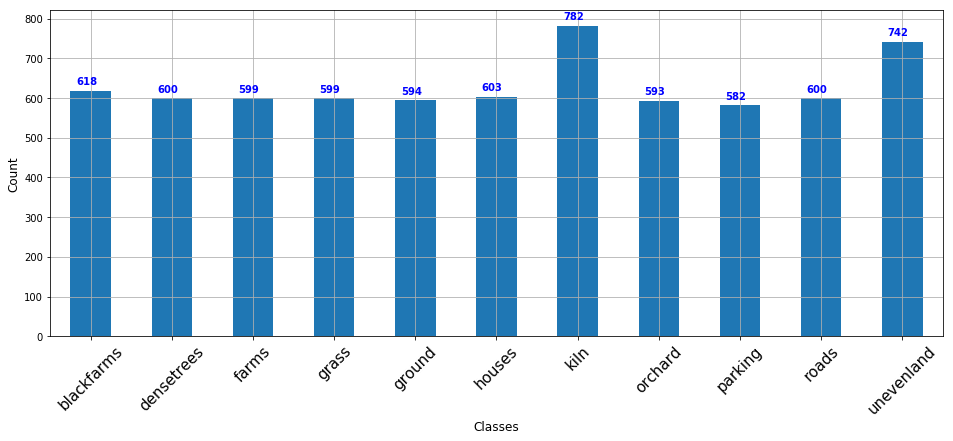

In [11]:
folders = os.listdir(dataset_path)
names, counts = [], []
for i, folder in enumerate(folders):
    dir_path = os.path.join(dataset_path, folder)
    images1 = os.listdir(dir_path)
    names.append(folder)
    counts.append(len(images1))
    print(i, folder, len(images1))
df = pd.DataFrame(data={'Name': names, 'Count': counts})
ax = df.plot(kind='bar', xticks=counts, grid=True, legend=False, figsize=(16,6))
ax.set_xlabel('Classes', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.xticks(np.arange(len(names)), names, rotation=45, fontsize=15)
for i, v in enumerate(counts):
    ax.text(i-.18, v+15, str(v), color='blue', fontweight='bold')
plt.show()

In [12]:
input_shape=(256,256,3)
# The '-1' is because we add a new class for finetuning
#model = resNet(input_shape, num_classes, model_type='resnet_152')
#model = VGG16(include_top=True, weights=None, input_tensor=None, input_shape=input_shape, pooling=None, classes=num_classes)
model =MyInceptionResNetV2(include_top=True, weights=None, input_tensor=None, input_shape=input_shape, pooling=None, classes=num_classes)

#model = resNet(input_shape, num_classes, model_type='resnet_34')
#model.load_weights(model_name+'.h5')
# model.load_weights('resNet152 (another copy).h5')

# # FINE TUNING HERE
# top_model = Sequential()
# top_model.add(Dense(input_shape=model.layers[-2].output_shape, units=num_classes, rnel
# kernel_initializer="he_normal", activation="softmax"))

# model.layers.pop()
# model.outputs = [model.layers[-1].output]
# model.layers[-1].outbound_nodes = []

# model = Model(inputs=model.inputs, outputs=top_model(model.outputs[0]))
# # for layer in model.layers[:-1]:
# #     layer.trainable = False

model.summary()
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# plot_model(model, to_file='model.png')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 127, 127, 32) 96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activat

In [18]:
class_weights = {0: 782/618,
                1: 782/600,
                2: 782/599,
                3: 782/599,
                4: 782/594,
                5: 782/603,
                6: 1,
                7: 782/593,
                8: 782/582,
                9: 782/600,
                10: 782/742
               }

In [19]:
print(class_weights)

{0: 1.2653721682847896, 1: 1.3033333333333332, 2: 1.3055091819699498, 3: 1.3055091819699498, 4: 1.3164983164983164, 5: 1.296849087893864, 6: 1, 7: 1.3187183811129848, 8: 1.3436426116838487, 9: 1.3033333333333332, 10: 1.0539083557951483}


In [20]:
batch_size = 40

Train ResNet-152 network using "fit_generator"

In [21]:
checkpoint = ModelCheckpoint('WEIGHTS/'+model_name+'.h5', monitor='val_loss', verbose=2, save_best_only=True, mode='auto')
tensorboard = TensorBoard(log_dir='TENSORBOARD/', batch_size=batch_size, write_graph=True, write_images=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=3, min_lr=0.00001)
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=2, mode='auto')
cvslogger = keras.callbacks.CSVLogger('WEIGHTS/'+model_name+'.csv', separator=',', append=True)
nb_epoch = 200
callbacks = [checkpoint, reduce_lr, earlystop, cvslogger, tensorboard]
#train_steps = int(len(y_train)//batch_size)
#val_steps = int(len(y_test)//batch_size)
kf = KFold(n_splits=10)
kf.get_n_splits(X)

#print(kf)  
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    train_gen = batch_generator(X_train, y_train, batch_size)
    test_gen = batch_generator(X_test, y_test, batch_size)
    history = model.fit_generator(train_gen, int(len(y_train)//batch_size), epochs=nb_epoch, verbose=1, 
                    max_queue_size=2, validation_data=test_gen, 
                    validation_steps=int(len(y_test)//batch_size), shuffle=True,
                    workers=1, use_multiprocessing= False, 
                    initial_epoch=0, callbacks=callbacks, class_weight=class_weights)
    #model.evaluate_generator(test_gen, steps=len(X[test])//batch_size


Epoch 1/200
155/155 [==============================] - 63s 408ms/step - loss: 0.6362 - acc: 0.8277 - val_loss: 11.7652 - val_acc: 0.0059

Epoch 00001: val_loss improved from inf to 11.76519, saving model to WEIGHTS/InceptionResNet-v2-10-3-3.h5
Epoch 2/200
155/155 [==============================] - 48s 311ms/step - loss: 0.2865 - acc: 0.9258 - val_loss: 13.8855 - val_acc: 0.0798

Epoch 00002: val_loss did not improve from 11.76519
Epoch 3/200
155/155 [==============================] - 48s 308ms/step - loss: 0.1849 - acc: 0.9494 - val_loss: 12.6377 - val_acc: 0.1074

Epoch 00003: val_loss did not improve from 11.76519
Epoch 4/200
155/155 [==============================] - 48s 308ms/step - loss: 0.1556 - acc: 0.9585 - val_loss: 12.1915 - val_acc: 0.1089

Epoch 00004: val_loss did not improve from 11.76519
Epoch 5/200
155/155 [==============================] - 49s 316ms/step - loss: 0.0935 - acc: 0.9774 - val_loss: 11.1072 - val_acc: 0.0951

Epoch 00005: val_loss improved from 11.76519 to 

155/155 [==============================] - 48s 312ms/step - loss: 0.1307 - acc: 0.9687 - val_loss: 0.1344 - val_acc: 0.9386

Epoch 00002: val_loss did not improve from 0.00231
Epoch 3/200
155/155 [==============================] - 48s 312ms/step - loss: 0.1225 - acc: 0.9703 - val_loss: 0.1404 - val_acc: 0.9355

Epoch 00003: val_loss did not improve from 0.00231
Epoch 4/200
155/155 [==============================] - 48s 312ms/step - loss: 0.1203 - acc: 0.9699 - val_loss: 0.1205 - val_acc: 0.9493

Epoch 00004: val_loss did not improve from 0.00231
Epoch 5/200
155/155 [==============================] - 48s 312ms/step - loss: 0.1222 - acc: 0.9711 - val_loss: 0.1342 - val_acc: 0.9386

Epoch 00005: val_loss did not improve from 0.00231
Epoch 6/200
155/155 [==============================] - 48s 312ms/step - loss: 0.1175 - acc: 0.9711 - val_loss: 0.1437 - val_acc: 0.9370

Epoch 00006: val_loss did not improve from 0.00231
Epoch 7/200
155/155 [==============================] - 48s 312ms/step - 

155/155 [==============================] - 48s 312ms/step - loss: 0.1262 - acc: 0.9685 - val_loss: 0.0145 - val_acc: 0.9954

Epoch 00002: val_loss did not improve from 0.00231
Epoch 3/200
155/155 [==============================] - 48s 312ms/step - loss: 0.1177 - acc: 0.9702 - val_loss: 0.0110 - val_acc: 0.9969

Epoch 00003: val_loss did not improve from 0.00231
Epoch 4/200
155/155 [==============================] - 48s 312ms/step - loss: 0.1124 - acc: 0.9723 - val_loss: 0.0179 - val_acc: 0.9939

Epoch 00004: val_loss did not improve from 0.00231
Epoch 5/200
155/155 [==============================] - 48s 312ms/step - loss: 0.1125 - acc: 0.9734 - val_loss: 0.0195 - val_acc: 0.9939

Epoch 00005: val_loss did not improve from 0.00231
Epoch 6/200
155/155 [==============================] - 48s 312ms/step - loss: 0.1065 - acc: 0.9740 - val_loss: 0.0200 - val_acc: 0.9923

Epoch 00006: val_loss did not improve from 0.00231
Epoch 7/200
155/155 [==============================] - 48s 312ms/step - 

# sanity check

In [ ]:
model.evaluate_generator(test_gen, steps=len(X_test)//batch_size)

In [19]:
def tuned_model(model, x):

    t_model = Model(model.input, x)
    
    return t_model


layer_dict = dict([(layer.name, layer) for layer in model.layers])
x = layer_dict['avg_pool'].output 

t_model = tuned_model(model, x)

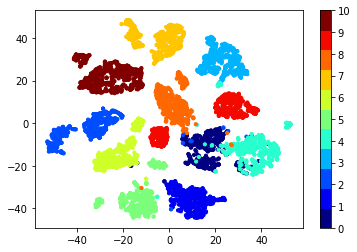

In [20]:
p_output = t_model.predict(X)
val_labels= np.argmax(y, axis=1)

import numpy as np
from keras.datasets import mnist
from matplotlib import pyplot as plt
from tsne import bh_sne

X = np.asarray(p_output).astype('float64')
X = X.reshape((p_output.shape[0], -1))
# For speed of computation, only run on a subset
#n = 20000
#X_train_data = X_train[:n]
#Y_train_data = y_train[:n]
# perform t-SNE embedding
vis_data = bh_sne(X)
# plot the result
vis_x = vis_data[:, 0]
vis_y = vis_data[:, 1]
f = plt.figure()
plt.scatter(vis_x, vis_y, c=val_labels, cmap=plt.cm.get_cmap("jet", 11), s=10)
plt.colorbar(ticks=range(11))
plt.show()
f.savefig("tsne_BrickKilns.pdf")

In [21]:
Tdataset_path = 'test'
Tpaths, Tlabels = read_landUse(Tdataset_path, '[(.png)(.jpg)]')
Timages = np.array([cv2.imread(image_name) for image_name in Tpaths]) 
X_test = Timages
y_test = to_categorical(Tlabels, num_classes)

In [22]:
y_pred = model.predict(X_test)

class_labels = {0: 'blackfarms', 1: 'densetrees', 2: 'farms', 3: 'grass', 4: 'ground',5: 'houses',6:'kiln',7:'orchard',8:'parking',9:'roads',10:'unevenland'}

In [23]:
preds=y_pred
print(preds.shape)

(1424, 11)


In [24]:
pres_classes = []
for p in preds.argmax(axis=1):
    pres_classes.append(class_labels[p])
#print(pres_classes)

In [25]:
truth_classes = []
for p in y_test.argmax(axis=1):
    truth_classes.append(class_labels[p])
#print(truth_classes)

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
def my_confusion_matrix(y_test, y_pred, classes):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=classes,title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,title='Normalized confusion matrix')

    plt.show()
    return cnf_matrix

Confusion matrix, without normalization
[[ 82   0   0   0  18   0   0   0   0   0   0]
 [  0  69  31   0   0   0   0   0   0   0   0]
 [  1   0  98   1   0   0   0   0   0   0   0]
 [  0   2   0  97   0   1   0   0   0   0   0]
 [  0   0   0   0  34   0   1   2   0   0  63]
 [  0   0   0   0   0 100   0   0   0   0   0]
 [  4   0   0   4   1 143 201   5   0   0  66]
 [  0   0   0   0   0   0   0 100   0   0   0]
 [  0   0   0   0   0   2   0   0  90   8   0]
 [ 11   0   0   0  17  10   0   0  10  52   0]
 [  0   0   0   0   0   0   0   0   0   0 100]]
Normalized confusion matrix
[[0.82 0.   0.   0.   0.18 0.   0.   0.   0.   0.   0.  ]
 [0.   0.69 0.31 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.01 0.   0.98 0.01 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.02 0.   0.97 0.   0.01 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.34 0.   0.01 0.02 0.   0.   0.63]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.01 0.   0.   0.01 0.   0.34 0.47 0.01 0.   0.   0.16]
 [0.   0

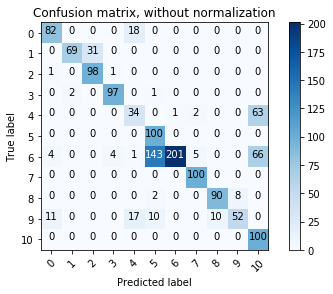

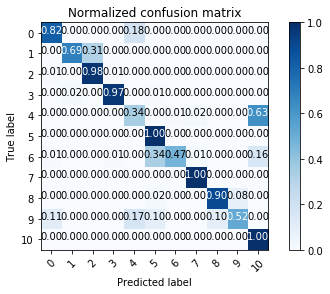

In [28]:
cm = my_confusion_matrix(truth_classes,pres_classes,class_labels)

In [29]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()
# Precision Calculation https://www.python-course.eu/confusion_matrix.php
# Precision Calculation https://www.python-course.eu/confusion_matrix.php
a = precision(6,cm)
b = recall(6,cm)
print('Precision', a)
print('Recall', b)
print('F1', (2*a*b)/(a+b))

Precision 0.995049504950495
Recall 0.4740566037735849
F1 0.6421725239616614


In [22]:
####################################################
# test_images_dir = 'lhr/newtask'
test_images_dir = 'kotRadhaTrain/'

# results_dir = 'results_lahore_17_with_old_wets_attempt2'
results_dir = 'KotRadhaResults-TinyIR/'
if not os.path.exists(results_dir):
    print('Creating new results directory "{}"'.format(results_dir))
    os.mkdir(results_dir)
im_dir = os.path.join(results_dir, 'images')
if not os.path.exists(im_dir):
    os.mkdir(im_dir)

#for file in os.listdir(test_images_dir):
#    curr_name, curr_ext = os.path.splitext(file)
 #   print(curr_name[:-1])
 #   break
#    new_name = curr_name[:-1]
#    os.rename(os.path.join(test_images_dir, file), os.path.join(test_images_dir, new_name+curr_ext))

########################################################
########### RENAMING DONE IN DOWNLOAD SCRIPT ###########
########################################################

In [23]:
## print('Waiting'len(images)len(images)len(images), end='', flush=True)len(images)
# while True:
    
 #   if len(os.listdir(test_images_dir)) != 544244:
 #      time.sleep(10*60)
 #       print('.', end='', flush=True)
 #       continue


# if os.path.exists(os.path.join(results_dir, 'houses.txt')) or os.path.exists(os.path.join(results_dir, 'test.csv')):
#     raise OSError('Result files already present, this script will append to the existing data.')
    
# label_names = {0: 'parking', 1: 'parks', 2: 'ground', 3: 'houses', 4: 'roads', 5: 'mosque', 6: 'densetrees', 7: 'kiln', 8: 'oiltanks', 9: 'tennis', 10: 'ponds', 11: 'grass', 12: 'blackfarms', 13: 'farms', 14: 'orchard'}
# label_names = {0: 'parking', 1: 'parks', 2: 'ground', 3: 'houses', 4: 'roads', 5: 'mosque', 6: 'densetrees', 7: 'kiln', 8: 'oiltanks', 9: 'tennis', 10: 'ponds', 11: 'grass', 12: 'blackfarms', 13: 'farms'}
# label_names = {0: 'blackfarms', 1: 'densetrees', 2: 'farms', 3: 'grass', 4: 'ground', 5: 'houses', 6: 'kiln', 7: 'mosque', 8: 'oiltanks', 9: 'orchard', 10: 'parking', 11: 'parks', 12: 'ponds', 13: 'roads', 14: 'tennis'}
label_names = {0: 'blackfarms', 1: 'densetrees', 2: 'farms', 3: 'grass', 4: 'ground', 5: 'houses', 6: 'kiln', 7: 'orchard', 8: 'parking', 9: 'roads', 10:'unevenland'}
y_tiles, x_tiles = [], []
label_probs = defaultdict(list)
top_label_probs = defaultdict(list)

# # Resuming check
# try:
#     with open(os.path.join(results_dir, 'last_file_done.txt'), 'r') as f:
#         loop_index = int(f.read())
#     print('Resuming from file index "{}"'.format(loop_index))
# except FileNotFoundError:
#     loop_index = 0
#     print('Starting fresh from file index "0"')

filenames = os.listdir(test_images_dir)

# # Missing images check
# try:
#     with open(os.path.join(results_dir, 'missing_images.txt'), 'r') as f:
#         missing_images = [name.strip() for name in f.readlines()]
#     print('Continuing with {} missing images.'.format(len(missing_images)))
# except FileNotFoundError:
#     missing_images = []
#     print('Starting fresh with empty missing images list')
for img_name in tqdm(filenames):


#     extt=img_name.split('.')[1]
    orig_name, extt = os.path.splitext(img_name)
    if(extt == '.jpg'):
        img_orig = cv2.imread(os.path.join(test_images_dir, img_name), cv2.IMREAD_COLOR)
        # To catch corrupt images
        if type(img_orig) == type(None):
            print('Skipping an image "{}"'.format(img_name))
        #    missing_images.append(img_name)
            continue

        img = np.expand_dims(img_orig, axis=0)
        class_name = img_name.split('.')[0]

        pred = model.predict(img, verbose=0)
    #    preds.append((pred.argmax(), pred.max(), class_name))

#         src = os.path.join(test_images_dir, img_name)
#         dst = os.path.join(results_dir, 'images', orig_name+'_'+label_names[pred.argmax()]+extt)
#         shutil.copyfile(src, dst)
#         print(img_name, dst)

#         break
        x_tile, y_tile = os.path.splitext(img_name)[0].split('_')
        y_tiles.append(y_tile)
        x_tiles.append(x_tile)

        # Append to individual results files on each itteration
        for i, label in label_names.items():
            file_path = os.path.join(results_dir, label+'.txt')
            label_probs[label].append(pred[0, i])
            with open(file_path, 'a') as f:
                f.write('{} {} {}\n'.format(y_tile, x_tile, pred[0, i]))
#         # Append to full result file on every 1000 itterations
#         #if loop_index % 1000 == 0:
#         d = {'y_tile': y_tiles, 'x_tile': x_tiles}
#         d.update(label_probs)
#         final_df = pd.DataFrame(data=d)
#         final_df.to_csv(os.path.join(results_dir, 'test.csv'), index=False, header=True)
        # Resuming 
        #with open('last_file_done.txt', 'w') as f:
         #   f.write(str(loop_index))
        # Write names of corrupted files for later use
        #with open(os.path.join(results_dir, 'missing.txt'), 'w') as f:
           # for i in missing_images:
           #     f.write('{}\n'.format(i))
        #loop_index += 1

        top3_inds = np.argsort(pred)
        top3_inds = np.flip(top3_inds, axis=1)
        top3_labels = [ label_names[i] for ia in top3_inds for i in ia ]
        top3_probs = pred[0, top3_inds]
#     print(top3_labels)

        for n in range(num_classes):
            top_label_probs['label'+str(n+1)].append(top3_labels[n])
            top_label_probs['prob'+str(n+1)].append(top3_probs[0, n])

# Append to full result file last time
d = {'y_tile': y_tiles, 'x_tile': x_tiles}
d.update(label_probs)
final_df = pd.DataFrame(data=d)
final_df.to_csv(os.path.join(results_dir, 'test.csv'), index=False, header=True)
# final_df

# Write names of corrupted files for later use
#with open(os.path.join(results_dir, 'missing.txt'), 'w') as f:
#    for i in missing_images:
#        f.write('{}\n'.format(i))

d = {'y_tile': y_tiles, 'x_tile': x_tiles}
d.update(top_label_probs)
sorted_df = pd.DataFrame(data=d)
sorted_df = sorted_df[['y_tile', 'x_tile', 'label1', 'prob1', 'label2', 'prob2', 'label3', 'prob3', 'label4', 'prob4', 'label5', 'prob5', 'label6', 'prob6', 'label7', 'prob7', 'label8', 'prob8', 'label9', 'prob9', 'label10', 'prob10']]
sorted_df.to_csv(os.path.join(results_dir, 'top_predictions.csv'), index=False, header=True)
# sorted_df.head()

# preds = sorted(preds, key=lambda x: x[0])
# for p_class, p_prob, truth in preds:
#     got_it = label_names[p_class] == truth
#     print('{}\tPrediction: {}\tTruth: {}\tProb: {}'.format(got_it, label_names[p_class], truth, p_prob))
#     break

  1%|          | 18/3090 [00:02<20:55,  2.45it/s] 

Skipping an image "74.11960601806641_31.24752044677734.jpg"


 76%|███████▌  | 2341/3090 [00:45<00:12, 61.06it/s]

Skipping an image "74.11960601806641_31.24271392822266.jpg"
Skipping an image "74.11960601806641_31.24340057373047.jpg"
Skipping an image "74.11960601806641_31.24408721923828.jpg"
Skipping an image "74.11960601806641_31.24477386474609.jpg"
Skipping an image "74.11960601806641_31.24546051025391.jpg"
Skipping an image "74.11960601806641_31.24614715576172.jpg"
Skipping an image "74.11960601806641_31.24683380126953.jpg"
Skipping an image "74.11960601806641_31.24820709228516.jpg"
Skipping an image "74.11960601806641_31.24889373779297.jpg"
Skipping an image "74.11960601806641_31.24958038330078.jpg"
Skipping an image "74.11960601806641_31.25026702880859.jpg"
Skipping an image "74.11960601806641_31.25095367431641.jpg"
Skipping an image "74.11960601806641_31.25164031982422.jpg"
Skipping an image "74.11960601806641_31.25232696533203.jpg"


 77%|███████▋  | 2385/3090 [00:46<00:10, 67.28it/s]

Skipping an image "74.12029266357422_31.23378753662109.jpg"
Skipping an image "74.12029266357422_31.23447418212891.jpg"
Skipping an image "74.12029266357422_31.23516082763672.jpg"
Skipping an image "74.12029266357422_31.23584747314453.jpg"
Skipping an image "74.12029266357422_31.23790740966797.jpg"
Skipping an image "74.12029266357422_31.23859405517578.jpg"


 81%|████████  | 2509/3090 [00:48<00:09, 58.14it/s]

Skipping an image "74.12029266357422_31.23241424560547.jpg"


 93%|█████████▎| 2860/3090 [00:54<00:03, 67.07it/s]

Skipping an image "74.12715911865234_31.23378753662109.jpg"
Skipping an image "74.12715911865234_31.23447418212891.jpg"
Skipping an image "74.12715911865234_31.23790740966797.jpg"
Skipping an image "74.12715911865234_31.23859405517578.jpg"
Skipping an image "74.12715911865234_31.23928070068359.jpg"
Skipping an image "74.12715911865234_31.24065399169922.jpg"
Skipping an image "74.12715911865234_31.24271392822266.jpg"


 96%|█████████▋| 2978/3090 [00:56<00:01, 63.07it/s]

Skipping an image "74.12715911865234_31.24202728271484.jpg"


100%|██████████| 3090/3090 [00:58<00:00, 60.44it/s]


In [30]:
####################################################
# test_images_dir = 'lhr/newtask'
test_images_dir = 'Kabul2NepalDatasets/Kabul2NepalZoom20Y2018_1_1000_Images/'

# results_dir = 'results_lahore_17_with_old_wets_attempt2'
results_dir = 'Results_v2/Kabul2NepalZoom20Y2018_1_1000_Images/'
if not os.path.exists(results_dir):
    print('Creating new results directory "{}"'.format(results_dir))
    os.mkdir(results_dir)
im_dir = os.path.join(results_dir, 'images')
if not os.path.exists(im_dir):
    os.mkdir(im_dir)

#for file in os.listdir(test_images_dir):
#    curr_name, curr_ext = os.path.splitext(file)
 #   print(curr_name[:-1])
 #   break
#    new_name = curr_name[:-1]
#    os.rename(os.path.join(test_images_dir, file), os.path.join(test_images_dir, new_name+curr_ext))

########################################################
########### RENAMING DONE IN DOWNLOAD SCRIPT ###########
########################################################

Testing the model and creating result files

In [ ]:
## print('Waiting'len(images)len(images)len(images), end='', flush=True)len(images)
# while True:
    
 #   if len(os.listdir(test_images_dir)) != 544244:
 #      time.sleep(10*60)
 #       print('.', end='', flush=True)
 #       continue


# if os.path.exists(os.path.join(results_dir, 'houses.txt')) or os.path.exists(os.path.join(results_dir, 'test.csv')):
#     raise OSError('Result files already present, this script will append to the existing data.')
    
# label_names = {0: 'parking', 1: 'parks', 2: 'ground', 3: 'houses', 4: 'roads', 5: 'mosque', 6: 'densetrees', 7: 'kiln', 8: 'oiltanks', 9: 'tennis', 10: 'ponds', 11: 'grass', 12: 'blackfarms', 13: 'farms', 14: 'orchard'}
# label_names = {0: 'parking', 1: 'parks', 2: 'ground', 3: 'houses', 4: 'roads', 5: 'mosque', 6: 'densetrees', 7: 'kiln', 8: 'oiltanks', 9: 'tennis', 10: 'ponds', 11: 'grass', 12: 'blackfarms', 13: 'farms'}
# label_names = {0: 'blackfarms', 1: 'densetrees', 2: 'farms', 3: 'grass', 4: 'ground', 5: 'houses', 6: 'kiln', 7: 'mosque', 8: 'oiltanks', 9: 'orchard', 10: 'parking', 11: 'parks', 12: 'ponds', 13: 'roads', 14: 'tennis'}
label_names = {0: 'blackfarms', 1: 'densetrees', 2: 'farms', 3: 'grass', 4: 'ground', 5: 'houses', 6: 'kiln', 7: 'orchard', 8: 'parking', 9: 'roads', 10:'unevenland'}
y_tiles, x_tiles = [], []
label_probs = defaultdict(list)
top_label_probs = defaultdict(list)

# # Resuming check
# try:
#     with open(os.path.join(results_dir, 'last_file_done.txt'), 'r') as f:
#         loop_index = int(f.read())
#     print('Resuming from file index "{}"'.format(loop_index))
# except FileNotFoundError:
#     loop_index = 0
#     print('Starting fresh from file index "0"')

filenames = os.listdir(test_images_dir)

# # Missing images check
# try:
#     with open(os.path.join(results_dir, 'missing_images.txt'), 'r') as f:
#         missing_images = [name.strip() for name in f.readlines()]
#     print('Continuing with {} missing images.'.format(len(missing_images)))
# except FileNotFoundError:
#     missing_images = []
#     print('Starting fresh with empty missing images list')
for img_name in tqdm(filenames):


#     extt=img_name.split('.')[1]
    orig_name, extt = os.path.splitext(img_name)
    if(extt == '.jpg'):
        img_orig = cv2.imread(os.path.join(test_images_dir, img_name), cv2.IMREAD_COLOR)
        # To catch corrupt images
        if type(img_orig) == type(None):
            print('Skipping an image "{}"'.format(img_name))
        #    missing_images.append(img_name)
            continue

        img = np.expand_dims(img_orig, axis=0)
        class_name = img_name.split('.')[0]

        pred = model.predict(img, verbose=0)
    #    preds.append((pred.argmax(), pred.max(), class_name))

#         src = os.path.join(test_images_dir, img_name)
#         dst = os.path.join(results_dir, 'images', orig_name+'_'+label_names[pred.argmax()]+extt)
#         shutil.copyfile(src, dst)
#         print(img_name, dst)

#         break
        x_tile, y_tile = os.path.splitext(img_name)[0].split('_')
        y_tiles.append(y_tile)
        x_tiles.append(x_tile)

        # Append to individual results files on each itteration
        for i, label in label_names.items():
            file_path = os.path.join(results_dir, label+'.txt')
            label_probs[label].append(pred[0, i])
            with open(file_path, 'a') as f:
                f.write('{} {} {}\n'.format(y_tile, x_tile, pred[0, i]))
#         # Append to full result file on every 1000 itterations
#         #if loop_index % 1000 == 0:
#         d = {'y_tile': y_tiles, 'x_tile': x_tiles}
#         d.update(label_probs)
#         final_df = pd.DataFrame(data=d)
#         final_df.to_csv(os.path.join(results_dir, 'test.csv'), index=False, header=True)
        # Resuming 
        #with open('last_file_done.txt', 'w') as f:
         #   f.write(str(loop_index))
        # Write names of corrupted files for later use
        #with open(os.path.join(results_dir, 'missing.txt'), 'w') as f:
           # for i in missing_images:
           #     f.write('{}\n'.format(i))
        #loop_index += 1

        top3_inds = np.argsort(pred)
        top3_inds = np.flip(top3_inds, axis=1)
        top3_labels = [ label_names[i] for ia in top3_inds for i in ia ]
        top3_probs = pred[0, top3_inds]
#     print(top3_labels)

        for n in range(num_classes):
            top_label_probs['label'+str(n+1)].append(top3_labels[n])
            top_label_probs['prob'+str(n+1)].append(top3_probs[0, n])

# Append to full result file last time
d = {'y_tile': y_tiles, 'x_tile': x_tiles}
d.update(label_probs)
final_df = pd.DataFrame(data=d)
final_df.to_csv(os.path.join(results_dir, 'test.csv'), index=False, header=True)
# final_df

# Write names of corrupted files for later use
#with open(os.path.join(results_dir, 'missing.txt'), 'w') as f:
#    for i in missing_images:
#        f.write('{}\n'.format(i))

d = {'y_tile': y_tiles, 'x_tile': x_tiles}
d.update(top_label_probs)
sorted_df = pd.DataFrame(data=d)
sorted_df = sorted_df[['y_tile', 'x_tile', 'label1', 'prob1', 'label2', 'prob2', 'label3', 'prob3', 'label4', 'prob4', 'label5', 'prob5', 'label6', 'prob6', 'label7', 'prob7', 'label8', 'prob8', 'label9', 'prob9', 'label10', 'prob10']]
sorted_df.to_csv(os.path.join(results_dir, 'top_predictions.csv'), index=False, header=True)
# sorted_df.head()

# preds = sorted(preds, key=lambda x: x[0])
# for p_class, p_prob, truth in preds:
#     got_it = label_names[p_class] == truth
#     print('{}\tPrediction: {}\tTruth: {}\tProb: {}'.format(got_it, label_names[p_class], truth, p_prob))
#     break

  1%|          | 443/64000 [00:15<36:45, 28.82it/s] 

In [ ]:
####################################################
# test_images_dir = 'lhr/newtask'
test_images_dir = 'Kabul2NepalDatasets/Kabul2NepalZoom20Y2018_1001_5000_Images/'

# results_dir = 'results_lahore_17_with_old_wets_attempt2'
results_dir = 'Results_v2/Kabul2NepalZoom20Y2018_1001_5000_Images/'
if not os.path.exists(results_dir):
    print('Creating new results directory "{}"'.format(results_dir))
    os.mkdir(results_dir)
im_dir = os.path.join(results_dir, 'images')
if not os.path.exists(im_dir):
    os.mkdir(im_dir)

#for file in os.listdir(test_images_dir):
#    curr_name, curr_ext = os.path.splitext(file)
 #   print(curr_name[:-1])
 #   break
#    new_name = curr_name[:-1]
#    os.rename(os.path.join(test_images_dir, file), os.path.join(test_images_dir, new_name+curr_ext))

########################################################
########### RENAMING DONE IN DOWNLOAD SCRIPT ###########
########################################################

In [ ]:
## print('Waiting'len(images)len(images)len(images), end='', flush=True)len(images)
# while True:
    
 #   if len(os.listdir(test_images_dir)) != 544244:
 #      time.sleep(10*60)
 #       print('.', end='', flush=True)
 #       continue


# if os.path.exists(os.path.join(results_dir, 'houses.txt')) or os.path.exists(os.path.join(results_dir, 'test.csv')):
#     raise OSError('Result files already present, this script will append to the existing data.')
    
# label_names = {0: 'parking', 1: 'parks', 2: 'ground', 3: 'houses', 4: 'roads', 5: 'mosque', 6: 'densetrees', 7: 'kiln', 8: 'oiltanks', 9: 'tennis', 10: 'ponds', 11: 'grass', 12: 'blackfarms', 13: 'farms', 14: 'orchard'}
# label_names = {0: 'parking', 1: 'parks', 2: 'ground', 3: 'houses', 4: 'roads', 5: 'mosque', 6: 'densetrees', 7: 'kiln', 8: 'oiltanks', 9: 'tennis', 10: 'ponds', 11: 'grass', 12: 'blackfarms', 13: 'farms'}
# label_names = {0: 'blackfarms', 1: 'densetrees', 2: 'farms', 3: 'grass', 4: 'ground', 5: 'houses', 6: 'kiln', 7: 'mosque', 8: 'oiltanks', 9: 'orchard', 10: 'parking', 11: 'parks', 12: 'ponds', 13: 'roads', 14: 'tennis'}
label_names = {0: 'blackfarms', 1: 'densetrees', 2: 'farms', 3: 'grass', 4: 'ground', 5: 'houses', 6: 'kiln', 7: 'orchard', 8: 'parking', 9: 'roads', 10:'unevenland'}
y_tiles, x_tiles = [], []
label_probs = defaultdict(list)
top_label_probs = defaultdict(list)

# # Resuming check
# try:
#     with open(os.path.join(results_dir, 'last_file_done.txt'), 'r') as f:
#         loop_index = int(f.read())
#     print('Resuming from file index "{}"'.format(loop_index))
# except FileNotFoundError:
#     loop_index = 0
#     print('Starting fresh from file index "0"')

filenames = os.listdir(test_images_dir)

# # Missing images check
# try:
#     with open(os.path.join(results_dir, 'missing_images.txt'), 'r') as f:
#         missing_images = [name.strip() for name in f.readlines()]
#     print('Continuing with {} missing images.'.format(len(missing_images)))
# except FileNotFoundError:
#     missing_images = []
#     print('Starting fresh with empty missing images list')
for img_name in tqdm(filenames):


#     extt=img_name.split('.')[1]
    orig_name, extt = os.path.splitext(img_name)
    if(extt == '.jpg'):
        img_orig = cv2.imread(os.path.join(test_images_dir, img_name), cv2.IMREAD_COLOR)
        # To catch corrupt images
        if type(img_orig) == type(None):
            print('Skipping an image "{}"'.format(img_name))
        #    missing_images.append(img_name)
            continue

        img = np.expand_dims(img_orig, axis=0)
        class_name = img_name.split('.')[0]

        pred = model.predict(img, verbose=0)
    #    preds.append((pred.argmax(), pred.max(), class_name))

#         src = os.path.join(test_images_dir, img_name)
#         dst = os.path.join(results_dir, 'images', orig_name+'_'+label_names[pred.argmax()]+extt)
#         shutil.copyfile(src, dst)
#         print(img_name, dst)

#         break
        x_tile, y_tile = os.path.splitext(img_name)[0].split('_')
        y_tiles.append(y_tile)
        x_tiles.append(x_tile)

        # Append to individual results files on each itteration
        for i, label in label_names.items():
            file_path = os.path.join(results_dir, label+'.txt')
            label_probs[label].append(pred[0, i])
            with open(file_path, 'a') as f:
                f.write('{} {} {}\n'.format(y_tile, x_tile, pred[0, i]))
#         # Append to full result file on every 1000 itterations
#         #if loop_index % 1000 == 0:
#         d = {'y_tile': y_tiles, 'x_tile': x_tiles}
#         d.update(label_probs)
#         final_df = pd.DataFrame(data=d)
#         final_df.to_csv(os.path.join(results_dir, 'test.csv'), index=False, header=True)
        # Resuming 
        #with open('last_file_done.txt', 'w') as f:
         #   f.write(str(loop_index))
        # Write names of corrupted files for later use
        #with open(os.path.join(results_dir, 'missing.txt'), 'w') as f:
           # for i in missing_images:
           #     f.write('{}\n'.format(i))
        #loop_index += 1

        top3_inds = np.argsort(pred)
        top3_inds = np.flip(top3_inds, axis=1)
        top3_labels = [ label_names[i] for ia in top3_inds for i in ia ]
        top3_probs = pred[0, top3_inds]
#     print(top3_labels)

        for n in range(num_classes):
            top_label_probs['label'+str(n+1)].append(top3_labels[n])
            top_label_probs['prob'+str(n+1)].append(top3_probs[0, n])

# Append to full result file last time
d = {'y_tile': y_tiles, 'x_tile': x_tiles}
d.update(label_probs)
final_df = pd.DataFrame(data=d)
final_df.to_csv(os.path.join(results_dir, 'test.csv'), index=False, header=True)
# final_df

# Write names of corrupted files for later use
#with open(os.path.join(results_dir, 'missing.txt'), 'w') as f:
#    for i in missing_images:
#        f.write('{}\n'.format(i))

d = {'y_tile': y_tiles, 'x_tile': x_tiles}
d.update(top_label_probs)
sorted_df = pd.DataFrame(data=d)
sorted_df = sorted_df[['y_tile', 'x_tile', 'label1', 'prob1', 'label2', 'prob2', 'label3', 'prob3', 'label4', 'prob4', 'label5', 'prob5', 'label6', 'prob6', 'label7', 'prob7', 'label8', 'prob8', 'label9', 'prob9', 'label10', 'prob10']]
sorted_df.to_csv(os.path.join(results_dir, 'top_predictions.csv'), index=False, header=True)
# sorted_df.head()

# preds = sorted(preds, key=lambda x: x[0])
# for p_class, p_prob, truth in preds:
#     got_it = label_names[p_class] == truth
#     print('{}\tPrediction: {}\tTruth: {}\tProb: {}'.format(got_it, label_names[p_class], truth, p_prob))
#     break

In [ ]:
####################################################
# test_images_dir = 'lhr/newtask'
test_images_dir = 'Kabul2NepalDatasets/Kabul2NepalZoom20Y2018_5001_10000_Images/'

# results_dir = 'results_lahore_17_with_old_wets_attempt2'
results_dir = 'Results_v2/Kabul2NepalZoom20Y2018_5001_10000_Images/'
if not os.path.exists(results_dir):
    print('Creating new results directory "{}"'.format(results_dir))
    os.mkdir(results_dir)
im_dir = os.path.join(results_dir, 'images')
if not os.path.exists(im_dir):
    os.mkdir(im_dir)

#for file in os.listdir(test_images_dir):
#    curr_name, curr_ext = os.path.splitext(file)
 #   print(curr_name[:-1])
 #   break
#    new_name = curr_name[:-1]
#    os.rename(os.path.join(test_images_dir, file), os.path.join(test_images_dir, new_name+curr_ext))

########################################################
########### RENAMING DONE IN DOWNLOAD SCRIPT ###########
########################################################

In [ ]:
## print('Waiting'len(images)len(images)len(images), end='', flush=True)len(images)
# while True:
    
 #   if len(os.listdir(test_images_dir)) != 544244:
 #      time.sleep(10*60)
 #       print('.', end='', flush=True)
 #       continue


# if os.path.exists(os.path.join(results_dir, 'houses.txt')) or os.path.exists(os.path.join(results_dir, 'test.csv')):
#     raise OSError('Result files already present, this script will append to the existing data.')
    
# label_names = {0: 'parking', 1: 'parks', 2: 'ground', 3: 'houses', 4: 'roads', 5: 'mosque', 6: 'densetrees', 7: 'kiln', 8: 'oiltanks', 9: 'tennis', 10: 'ponds', 11: 'grass', 12: 'blackfarms', 13: 'farms', 14: 'orchard'}
# label_names = {0: 'parking', 1: 'parks', 2: 'ground', 3: 'houses', 4: 'roads', 5: 'mosque', 6: 'densetrees', 7: 'kiln', 8: 'oiltanks', 9: 'tennis', 10: 'ponds', 11: 'grass', 12: 'blackfarms', 13: 'farms'}
# label_names = {0: 'blackfarms', 1: 'densetrees', 2: 'farms', 3: 'grass', 4: 'ground', 5: 'houses', 6: 'kiln', 7: 'mosque', 8: 'oiltanks', 9: 'orchard', 10: 'parking', 11: 'parks', 12: 'ponds', 13: 'roads', 14: 'tennis'}
label_names = {0: 'blackfarms', 1: 'densetrees', 2: 'farms', 3: 'grass', 4: 'ground', 5: 'houses', 6: 'kiln', 7: 'orchard', 8: 'parking', 9: 'roads', 10:'unevenland'}
y_tiles, x_tiles = [], []
label_probs = defaultdict(list)
top_label_probs = defaultdict(list)

# # Resuming check
# try:
#     with open(os.path.join(results_dir, 'last_file_done.txt'), 'r') as f:
#         loop_index = int(f.read())
#     print('Resuming from file index "{}"'.format(loop_index))
# except FileNotFoundError:
#     loop_index = 0
#     print('Starting fresh from file index "0"')

filenames = os.listdir(test_images_dir)

# # Missing images check
# try:
#     with open(os.path.join(results_dir, 'missing_images.txt'), 'r') as f:
#         missing_images = [name.strip() for name in f.readlines()]
#     print('Continuing with {} missing images.'.format(len(missing_images)))
# except FileNotFoundError:
#     missing_images = []
#     print('Starting fresh with empty missing images list')
for img_name in tqdm(filenames):


#     extt=img_name.split('.')[1]
    orig_name, extt = os.path.splitext(img_name)
    if(extt == '.jpg'):
        img_orig = cv2.imread(os.path.join(test_images_dir, img_name), cv2.IMREAD_COLOR)
        # To catch corrupt images
        if type(img_orig) == type(None):
            print('Skipping an image "{}"'.format(img_name))
        #    missing_images.append(img_name)
            continue

        img = np.expand_dims(img_orig, axis=0)
        class_name = img_name.split('.')[0]

        pred = model.predict(img, verbose=0)
    #    preds.append((pred.argmax(), pred.max(), class_name))

#         src = os.path.join(test_images_dir, img_name)
#         dst = os.path.join(results_dir, 'images', orig_name+'_'+label_names[pred.argmax()]+extt)
#         shutil.copyfile(src, dst)
#         print(img_name, dst)

#         break
        x_tile, y_tile = os.path.splitext(img_name)[0].split('_')
        y_tiles.append(y_tile)
        x_tiles.append(x_tile)

        # Append to individual results files on each itteration
        for i, label in label_names.items():
            file_path = os.path.join(results_dir, label+'.txt')
            label_probs[label].append(pred[0, i])
            with open(file_path, 'a') as f:
                f.write('{} {} {}\n'.format(y_tile, x_tile, pred[0, i]))
#         # Append to full result file on every 1000 itterations
#         #if loop_index % 1000 == 0:
#         d = {'y_tile': y_tiles, 'x_tile': x_tiles}
#         d.update(label_probs)
#         final_df = pd.DataFrame(data=d)
#         final_df.to_csv(os.path.join(results_dir, 'test.csv'), index=False, header=True)
        # Resuming 
        #with open('last_file_done.txt', 'w') as f:
         #   f.write(str(loop_index))
        # Write names of corrupted files for later use
        #with open(os.path.join(results_dir, 'missing.txt'), 'w') as f:
           # for i in missing_images:
           #     f.write('{}\n'.format(i))
        #loop_index += 1

        top3_inds = np.argsort(pred)
        top3_inds = np.flip(top3_inds, axis=1)
        top3_labels = [ label_names[i] for ia in top3_inds for i in ia ]
        top3_probs = pred[0, top3_inds]
#     print(top3_labels)

        for n in range(num_classes):
            top_label_probs['label'+str(n+1)].append(top3_labels[n])
            top_label_probs['prob'+str(n+1)].append(top3_probs[0, n])

# Append to full result file last time
d = {'y_tile': y_tiles, 'x_tile': x_tiles}
d.update(label_probs)
final_df = pd.DataFrame(data=d)
final_df.to_csv(os.path.join(results_dir, 'test.csv'), index=False, header=True)
# final_df

# Write names of corrupted files for later use
#with open(os.path.join(results_dir, 'missing.txt'), 'w') as f:
#    for i in missing_images:
#        f.write('{}\n'.format(i))

d = {'y_tile': y_tiles, 'x_tile': x_tiles}
d.update(top_label_probs)
sorted_df = pd.DataFrame(data=d)
sorted_df = sorted_df[['y_tile', 'x_tile', 'label1', 'prob1', 'label2', 'prob2', 'label3', 'prob3', 'label4', 'prob4', 'label5', 'prob5', 'label6', 'prob6', 'label7', 'prob7', 'label8', 'prob8', 'label9', 'prob9', 'label10', 'prob10']]
sorted_df.to_csv(os.path.join(results_dir, 'top_predictions.csv'), index=False, header=True)
# sorted_df.head()

# preds = sorted(preds, key=lambda x: x[0])
# for p_class, p_prob, truth in preds:
#     got_it = label_names[p_class] == truth
#     print('{}\tPrediction: {}\tTruth: {}\tProb: {}'.format(got_it, label_names[p_class], truth, p_prob))
#     break

In [ ]:
####################################################
# test_images_dir = 'lhr/newtask'
test_images_dir = 'Kabul2NepalDatasets/Kabul2NepalZoom20Y2018_10000_15000_Images/'

# results_dir = 'results_lahore_17_with_old_wets_attempt2'
results_dir = 'Results_v2/Kabul2NepalZoom20Y2018_10000_15000_Images/'
if not os.path.exists(results_dir):
    print('Creating new results directory "{}"'.format(results_dir))
    os.mkdir(results_dir)
im_dir = os.path.join(results_dir, 'images')
if not os.path.exists(im_dir):
    os.mkdir(im_dir)

#for file in os.listdir(test_images_dir):
#    curr_name, curr_ext = os.path.splitext(file)
 #   print(curr_name[:-1])
 #   break
#    new_name = curr_name[:-1]
#    os.rename(os.path.join(test_images_dir, file), os.path.join(test_images_dir, new_name+curr_ext))

########################################################
########### RENAMING DONE IN DOWNLOAD SCRIPT ###########
########################################################

In [ ]:
## print('Waiting'len(images)len(images)len(images), end='', flush=True)len(images)
# while True:
    
 #   if len(os.listdir(test_images_dir)) != 544244:
 #      time.sleep(10*60)
 #       print('.', end='', flush=True)
 #       continue


# if os.path.exists(os.path.join(results_dir, 'houses.txt')) or os.path.exists(os.path.join(results_dir, 'test.csv')):
#     raise OSError('Result files already present, this script will append to the existing data.')
    
# label_names = {0: 'parking', 1: 'parks', 2: 'ground', 3: 'houses', 4: 'roads', 5: 'mosque', 6: 'densetrees', 7: 'kiln', 8: 'oiltanks', 9: 'tennis', 10: 'ponds', 11: 'grass', 12: 'blackfarms', 13: 'farms', 14: 'orchard'}
# label_names = {0: 'parking', 1: 'parks', 2: 'ground', 3: 'houses', 4: 'roads', 5: 'mosque', 6: 'densetrees', 7: 'kiln', 8: 'oiltanks', 9: 'tennis', 10: 'ponds', 11: 'grass', 12: 'blackfarms', 13: 'farms'}
# label_names = {0: 'blackfarms', 1: 'densetrees', 2: 'farms', 3: 'grass', 4: 'ground', 5: 'houses', 6: 'kiln', 7: 'mosque', 8: 'oiltanks', 9: 'orchard', 10: 'parking', 11: 'parks', 12: 'ponds', 13: 'roads', 14: 'tennis'}
label_names = {0: 'blackfarms', 1: 'densetrees', 2: 'farms', 3: 'grass', 4: 'ground', 5: 'houses', 6: 'kiln', 7: 'orchard', 8: 'parking', 9: 'roads', 10:'unevenland'}
y_tiles, x_tiles = [], []
label_probs = defaultdict(list)
top_label_probs = defaultdict(list)

# # Resuming check
# try:
#     with open(os.path.join(results_dir, 'last_file_done.txt'), 'r') as f:
#         loop_index = int(f.read())
#     print('Resuming from file index "{}"'.format(loop_index))
# except FileNotFoundError:
#     loop_index = 0
#     print('Starting fresh from file index "0"')

filenames = os.listdir(test_images_dir)

# # Missing images check
# try:
#     with open(os.path.join(results_dir, 'missing_images.txt'), 'r') as f:
#         missing_images = [name.strip() for name in f.readlines()]
#     print('Continuing with {} missing images.'.format(len(missing_images)))
# except FileNotFoundError:
#     missing_images = []
#     print('Starting fresh with empty missing images list')
for img_name in tqdm(filenames):


#     extt=img_name.split('.')[1]
    orig_name, extt = os.path.splitext(img_name)
    if(extt == '.jpg'):
        img_orig = cv2.imread(os.path.join(test_images_dir, img_name), cv2.IMREAD_COLOR)
        # To catch corrupt images
        if type(img_orig) == type(None):
            print('Skipping an image "{}"'.format(img_name))
        #    missing_images.append(img_name)
            continue

        img = np.expand_dims(img_orig, axis=0)
        class_name = img_name.split('.')[0]

        pred = model.predict(img, verbose=0)
    #    preds.append((pred.argmax(), pred.max(), class_name))

#         src = os.path.join(test_images_dir, img_name)
#         dst = os.path.join(results_dir, 'images', orig_name+'_'+label_names[pred.argmax()]+extt)
#         shutil.copyfile(src, dst)
#         print(img_name, dst)

#         break
        x_tile, y_tile = os.path.splitext(img_name)[0].split('_')
        y_tiles.append(y_tile)
        x_tiles.append(x_tile)

        # Append to individual results files on each itteration
        for i, label in label_names.items():
            file_path = os.path.join(results_dir, label+'.txt')
            label_probs[label].append(pred[0, i])
            with open(file_path, 'a') as f:
                f.write('{} {} {}\n'.format(y_tile, x_tile, pred[0, i]))
#         # Append to full result file on every 1000 itterations
#         #if loop_index % 1000 == 0:
#         d = {'y_tile': y_tiles, 'x_tile': x_tiles}
#         d.update(label_probs)
#         final_df = pd.DataFrame(data=d)
#         final_df.to_csv(os.path.join(results_dir, 'test.csv'), index=False, header=True)
        # Resuming 
        #with open('last_file_done.txt', 'w') as f:
         #   f.write(str(loop_index))
        # Write names of corrupted files for later use
        #with open(os.path.join(results_dir, 'missing.txt'), 'w') as f:
           # for i in missing_images:
           #     f.write('{}\n'.format(i))
        #loop_index += 1

        top3_inds = np.argsort(pred)
        top3_inds = np.flip(top3_inds, axis=1)
        top3_labels = [ label_names[i] for ia in top3_inds for i in ia ]
        top3_probs = pred[0, top3_inds]
#     print(top3_labels)

        for n in range(num_classes):
            top_label_probs['label'+str(n+1)].append(top3_labels[n])
            top_label_probs['prob'+str(n+1)].append(top3_probs[0, n])

# Append to full result file last time
d = {'y_tile': y_tiles, 'x_tile': x_tiles}
d.update(label_probs)
final_df = pd.DataFrame(data=d)
final_df.to_csv(os.path.join(results_dir, 'test.csv'), index=False, header=True)
# final_df

# Write names of corrupted files for later use
#with open(os.path.join(results_dir, 'missing.txt'), 'w') as f:
#    for i in missing_images:
#        f.write('{}\n'.format(i))

d = {'y_tile': y_tiles, 'x_tile': x_tiles}
d.update(top_label_probs)
sorted_df = pd.DataFrame(data=d)
sorted_df = sorted_df[['y_tile', 'x_tile', 'label1', 'prob1', 'label2', 'prob2', 'label3', 'prob3', 'label4', 'prob4', 'label5', 'prob5', 'label6', 'prob6', 'label7', 'prob7', 'label8', 'prob8', 'label9', 'prob9', 'label10', 'prob10']]
sorted_df.to_csv(os.path.join(results_dir, 'top_predictions.csv'), index=False, header=True)
# sorted_df.head()

# preds = sorted(preds, key=lambda x: x[0])
# for p_class, p_prob, truth in preds:
#     got_it = label_names[p_class] == truth
#     print('{}\tPrediction: {}\tTruth: {}\tProb: {}'.format(got_it, label_names[p_class], truth, p_prob))
#     break